In [1]:

%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.kernel_approximation import *
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.neural_network import *
from sklearn.linear_model import *
import xgboost as xgb
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, MissingIndicator
from statsmodels.tsa.statespace.sarimax import SARIMAX
from imblearn.over_sampling import SMOTE
from imblearn.combine import *
from imblearn.ensemble import *

from numba import jit


df = load_df()

# from tweedejaars_project import config
# df["reconstruction"] = np.log1p(load_df(config.PROCESSED_DATA_DIR / "reconstruction_error.pkl"))
# df["last_15min_recon"] = df["reconstruction"].rolling(10080, 1).median()
# df["recon_diff"] = df["last_15min_recon"].diff()

# mask = df["fix_two_sided_ptu_realtime"].fillna(False)
# df["last_15min_recon_true"] = np.nan
# df.loc[mask, "last_15min_recon_true"] = df.loc[mask, "reconstruction"].rolling(10080, 1).median()
# df["last_15min_recon_true"] = df["last_15min_recon_true"].ffill()
# df["recon_diff_true"] = df["last_15min_recon_true"] - df["reconstruction"]

# mask = ~df["fix_two_sided_ptu_realtime"].fillna(False)
# df["last_15min_recon_false"] = np.nan
# df.loc[mask, "last_15min_recon_false"] = df.loc[mask, "reconstruction"].rolling(10080, 1).median()
# df["last_15min_recon_false"] = df["last_15min_recon_false"].ffill()
# df["recon_diff_false"] = df["last_15min_recon_false"] - df["reconstruction"]

# df["recon_diff_base"] = df["last_15min_recon_true"] - df["last_15min_recon_false"]

# df["recon_diff_total"] = (df["recon_diff_true"] - df["recon_diff_false"]) - (df["recon_diff"] - df["recon_diff_false"])

# encoded = load_df(config.PROCESSED_DATA_DIR / "encoded.pkl")
# encoded.columns = [str(i) for i in range(32)]

# df = pd.concat([df, encoded], axis=1)

# price_pred = load_df(config.PROCESSED_DATA_DIR / "price_pred.pkl")
# df["price_pred"] = price_pred

# df.fillna(0, inplace=True)

# eneco_df = pd.read_csv(config.PROCESSED_DATA_DIR / "model_predictions_eneco.csv")
# df["eneco_pred"] = eneco_df["model_prediction"]

version = "target"
target = "fix_two_sided_ptu"
train_set = "train"
test_set = "valid"

Number of used features: 44
count    16.000000
mean      0.038070
std       0.005569
min       0.022732
25%       0.037322
50%       0.039063
75%       0.041564
max       0.043857
Name: 0, dtype: float64


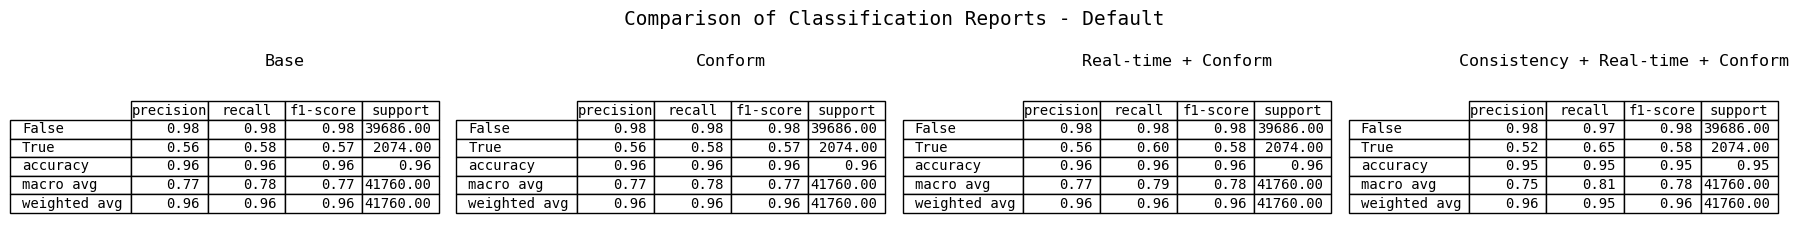

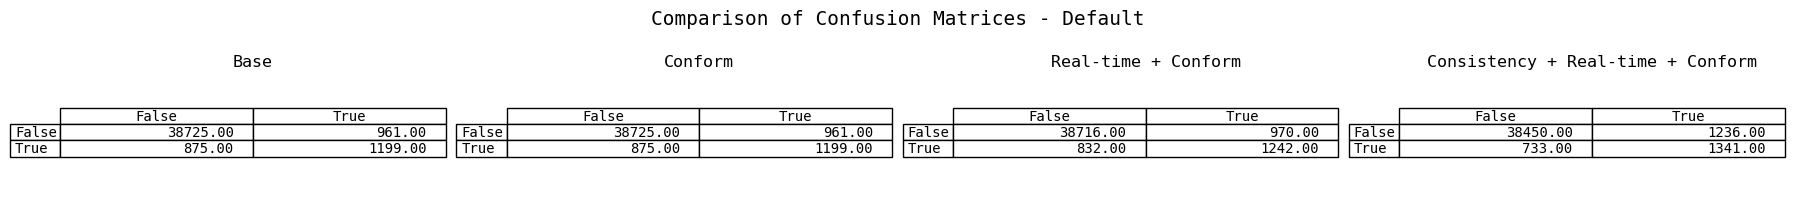

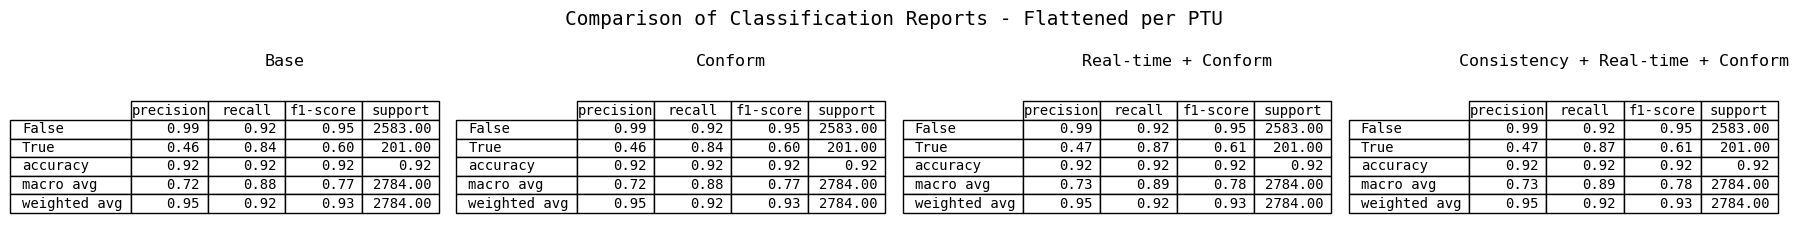

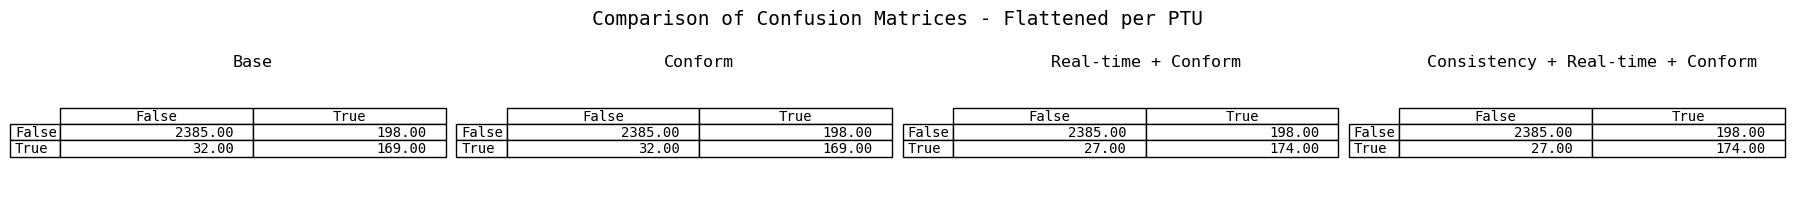

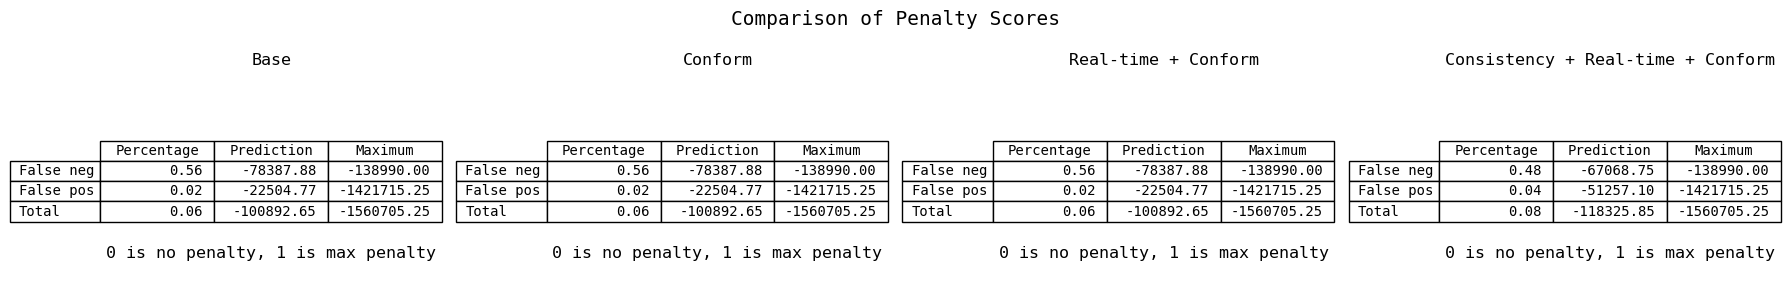

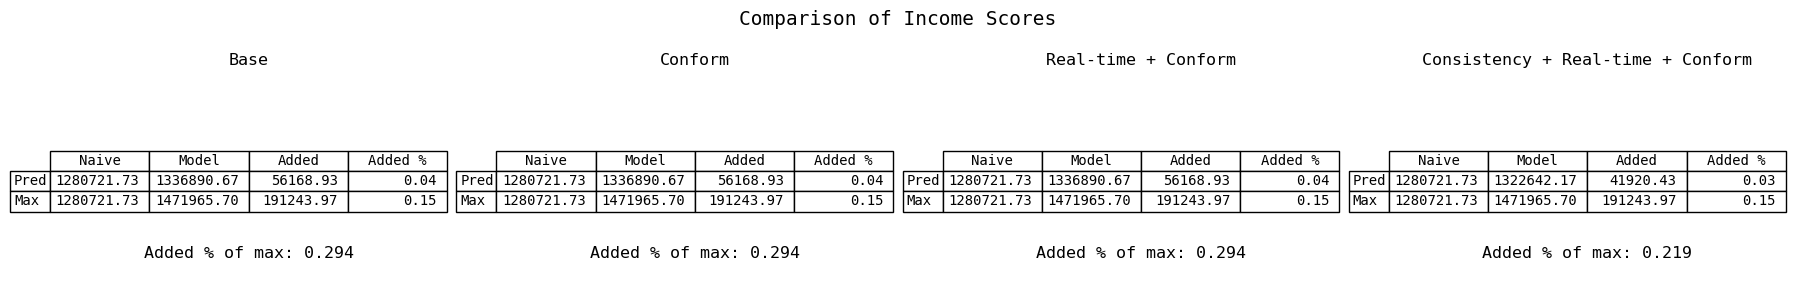

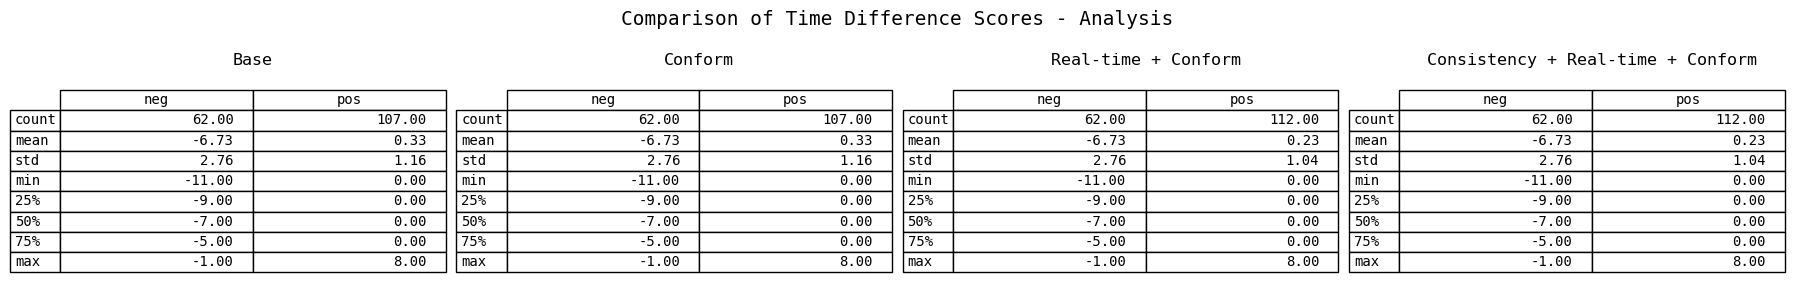

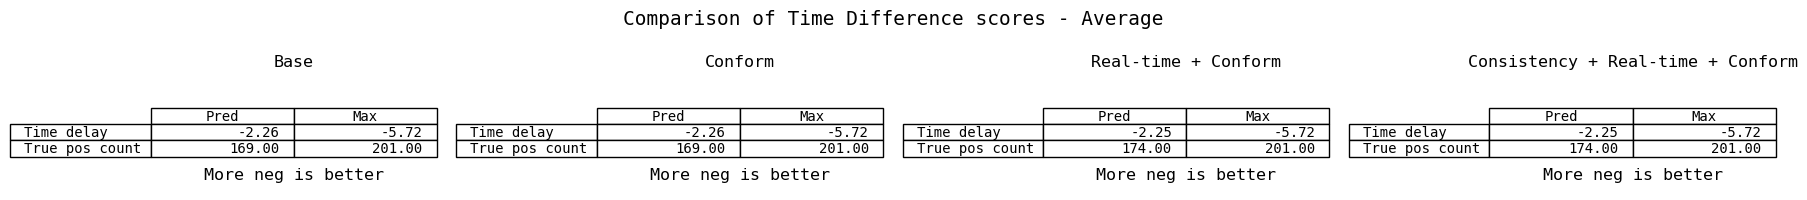

In [2]:
features = [
    "import_capacity",
    "min_price_published",
    "mid_price_published",
    "max_price_published",
    "min_ptu_price_known",
    "max_ptu_price_known",
    "fix_min_ptu_price_known",  # combine all
    "fix_max_ptu_price_known",  # combine all
    "fix_settlement_price_bestguess_alt",  # combine all
    "settlement_price_bestguess_alt",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # "igcc_contribution_up_published",
    # "igcc_contribution_down_published",
    "time_since_last_two_sided",
    "time_since_last_two_sided_alt",  # combine all
    "two_sided_daily_count",
    "PTU",
    "minute_in_ptu",
    "naive_strategy_action",
    "vwap_avg",
    "vwap_std",
    "vwap_median",
    "vwap_qty_sum",
    "hvq_delta",
    # "forecast_wind",
    # "forecast_solar",
    # "forecast_demand",
    # "forecast_wind_delta",
    # "forecast_solar_delta",
    # "forecast_demand_delta",
    "fix_two_sided_ptu_realtime",
    "residual_load",
    "dispatch_diff",
    "igcc_diff",
    "is_balanced",
    "weekday",
    "workday",
    # "hour",
    "month",
    # "day",
    # "minute",
    # "down_negative",
    "down_price_volume",
    "up_price_volume",
    # "diff_price_volume",
    # "started_down",
    # "max_price_filled_known",
    "last_15min_up_volume",
    "last_15min_down_volume",
    "downward_dispatch_published_peak",
    "downward_dispatch_published_peak_time",
    "downward_dispatch_published_peak_diff",
    # "upward_dispatch_published_peak",
    # "upward_dispatch_published_peak_time",
    # "upward_dispatch_published_peak_diff",
    "igcc_contribution_down_published_peak",
    "igcc_contribution_down_published_peak_time",
    "igcc_contribution_down_published_peak_diff",
    # "igcc_contribution_up_published_peak",
    # "igcc_contribution_up_published_peak_time",
    # "igcc_contribution_up_published_peak_diff",
    # "reconstruction",
    # "last_15min_recon",
    # "recon_diff",
    # "last_15min_recon_true",
    # "recon_diff_true",
    # "last_15min_recon_false",
    # "recon_diff_false",
    # "recon_diff_base",
    # "recon_diff_total",
    # "price_pred",
    # "eneco_pred",
    "min_price_published_1",
    "max_price_published_1",
    "fix_two_sided_ptu_17",
    "settlement_price_realized_17",
    "minute_in_ptu_2"
]

print("Number of used features:", len(features))
splits = get_splits(df, features, target, return_dict_pair=False)



def train(train_in, train_out):
    model = HistGradientBoostingRegressor(loss="poisson", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # model = RandomForestRegressor(n_estimators=200, criterion="poisson", max_features="log2", n_jobs=-1)
    # model = xgb.XGBClassifier(objective="binary:hinge", subsample=0.9, tree_method="hist", grow_policy="lossguide", max_depth=8)
    # h = HistGradientBoostingClassifier(scoring="average_precision", l2_regularization=8, learning_rate=0.05, validation_fraction=0.5, categorical_features="from_dtype")
    # f = RandomForestClassifier(n_estimators=50, criterion="log_loss", max_features="log2", class_weight="balanced", n_jobs=-1)
    # r = RUSBoostClassifier()
    # b = BalancedBaggingClassifier(n_jobs=-1)
    # model = VotingClassifier(
    #     [
    #         ("hist", h),
    #         ("rus", r),
    #         ("bal", b),
    #         ("rf", f)
    #     ],
    #     voting="soft",
    #     n_jobs=-1
    # )
    
    model = model.fit(train_in, train_out)
    
    return model


def test(model, test_in):
    pred = model.predict(test_in)
    return recast_pred(pred > 0.5), pred


# splits[train_set][3]["neg"] = splits[train_set][3]["min_price_published"] < 0
# mask = splits[train_set][3].groupby("ptu_id")["neg"].transform("any")
# mask = splits[train_set][3].groupby("ptu_id")["naive_strategy_action"].transform("any")
# mask = mask | splits[train_set][3]["fix_two_sided_ptu"]
# mask = splits[train_set][3]["naive_strategy_action"] | splits[train_set][3]["fix_two_sided_ptu"]

# mask = ~splits[train_set][3]["minute_in_ptu"].isin([0, 1])  # Maybe prob no
mask = splits[train_set][3]["started_down"]

t = np.ones(len(mask), dtype=bool)
t[:15 * 2] = False
mask = mask & t

# mask = splits[train_set][3]["min_ptu_price_known"] < 0


X_train = splits[train_set][0][mask]
y_train = splits[train_set][1][mask]

# smote = SMOTETomek()
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train.fillna(0))
# print("start")
# best1, _ = evaluate_income(train, test, X_train_resampled, y_train_resampled, splits[test_set][0], splits[test_set][3], repeat=128)
best2, _ = evaluate_income(train, test, X_train, y_train, splits[test_set][0], splits[test_set][3], repeat=16)

# p1, p1p = test(best1[0], splits[test_set][0])
p2, p2p = test(best2[0], splits[test_set][0])
# p = p1 & p2
p = p2
show_metrics_adjusted(splits[test_set][3], p, version=version)

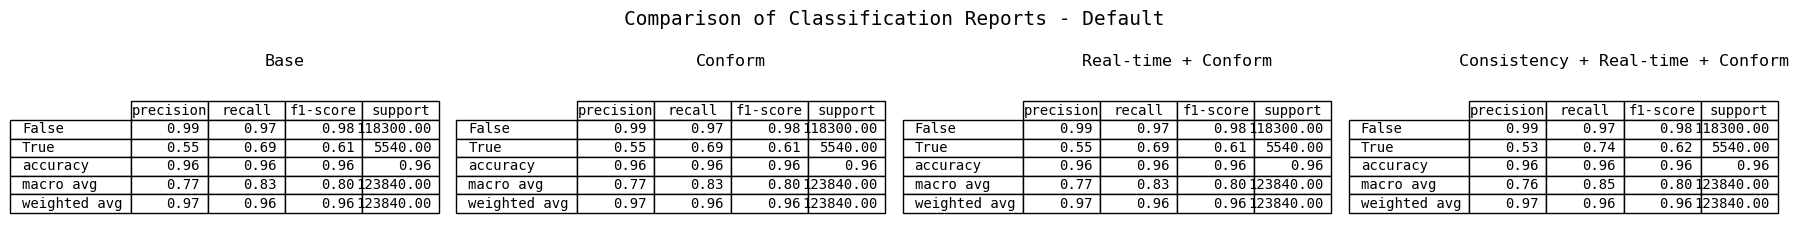

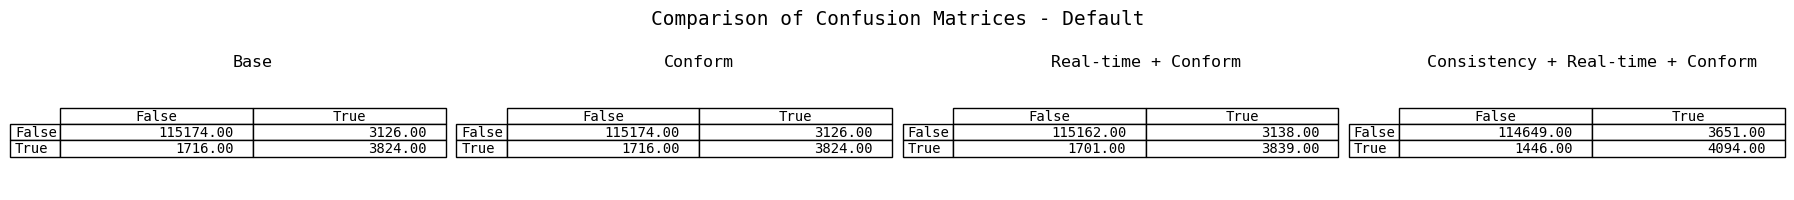

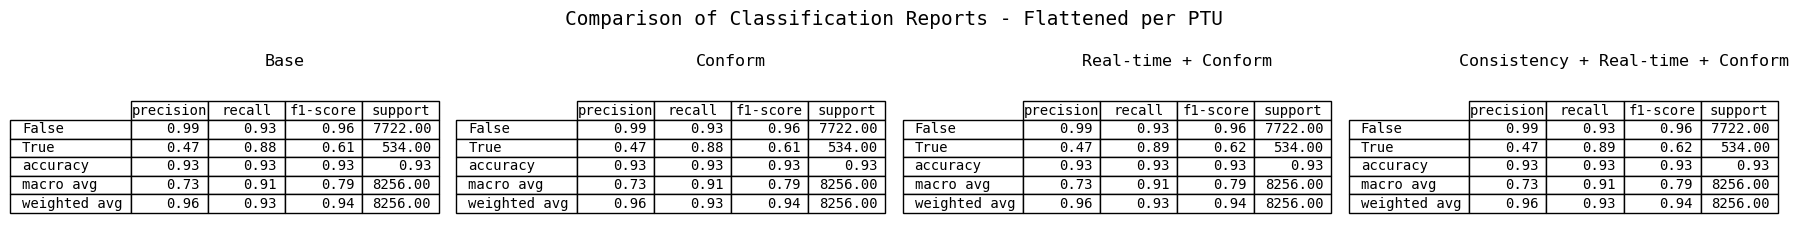

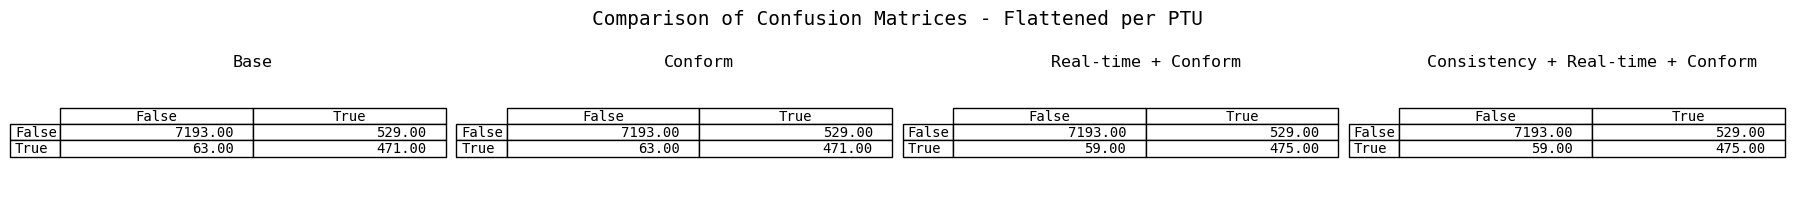

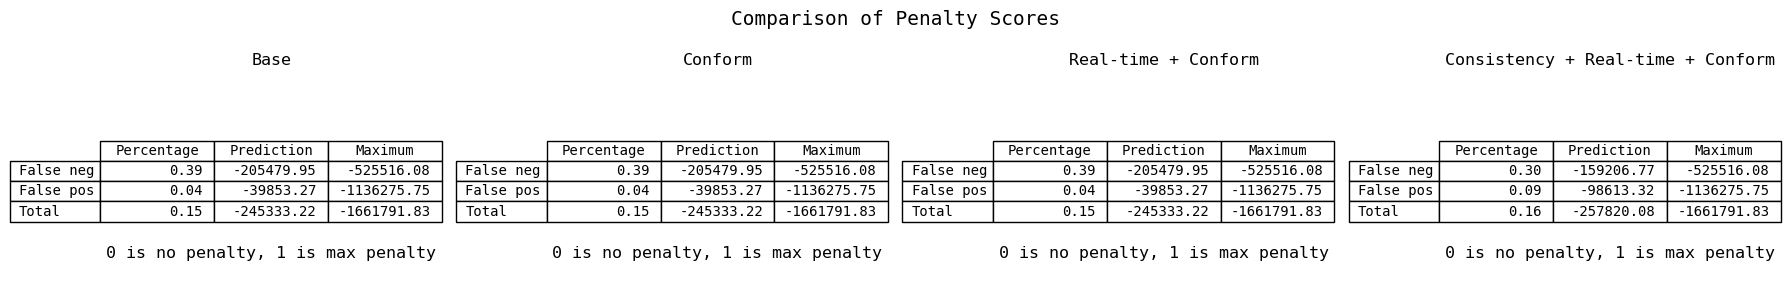

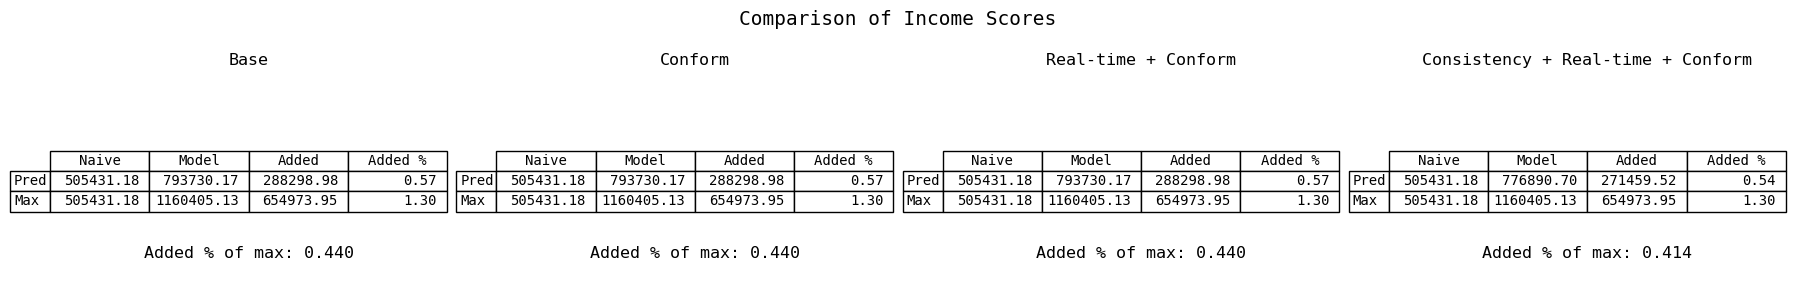

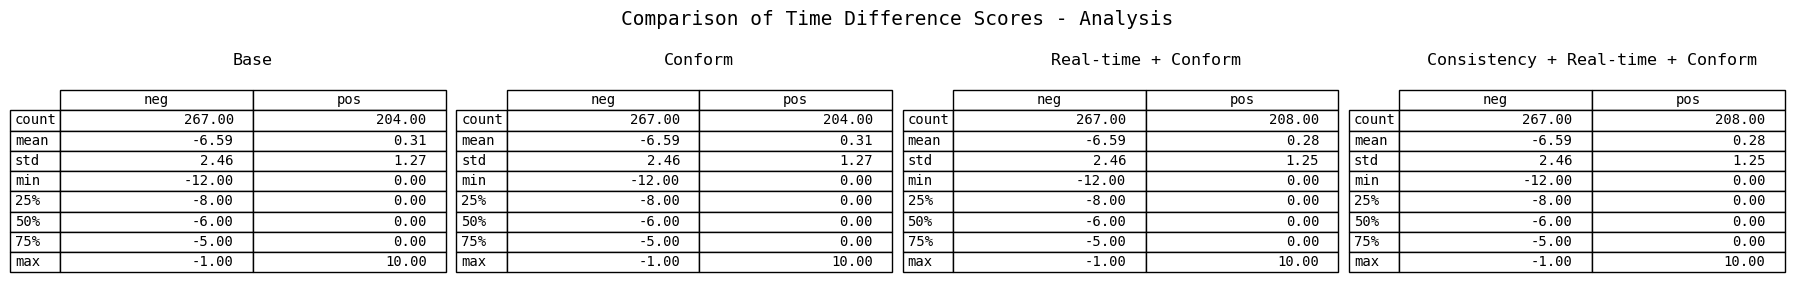

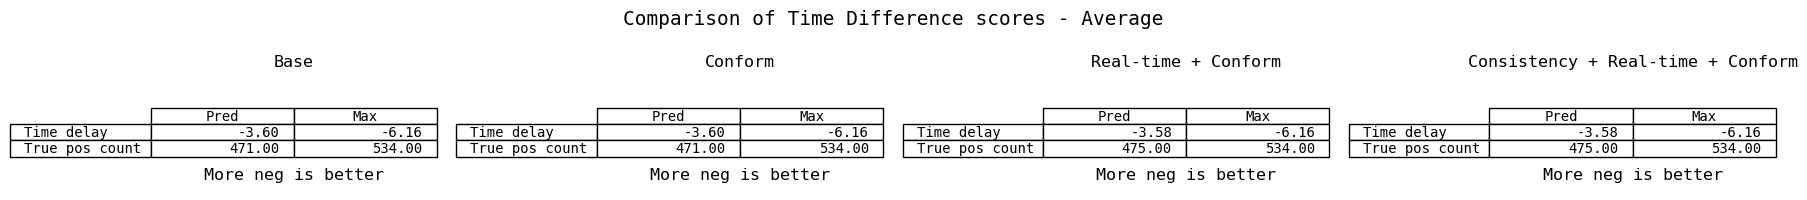

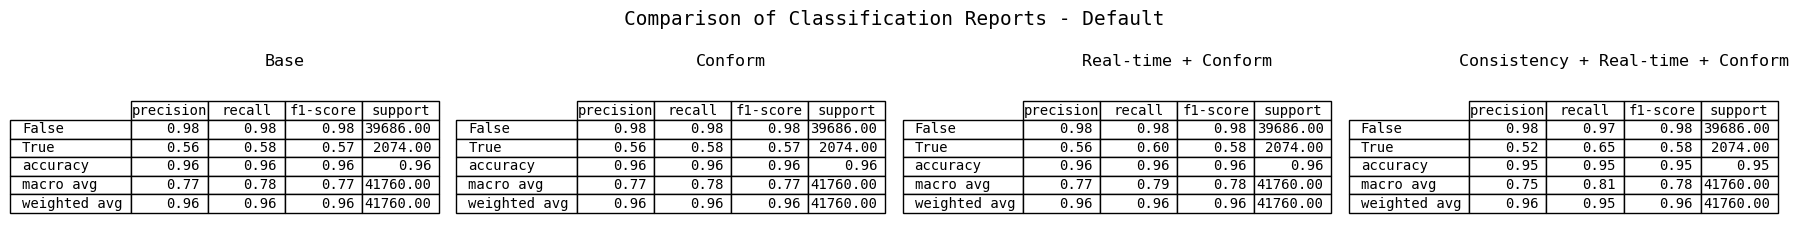

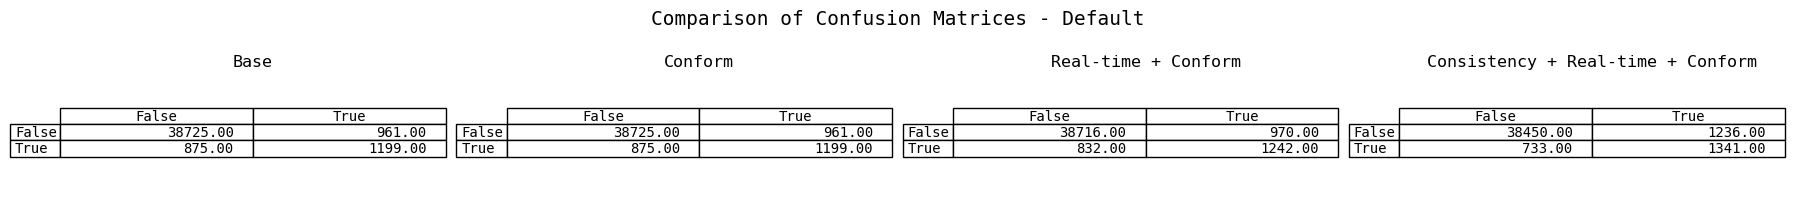

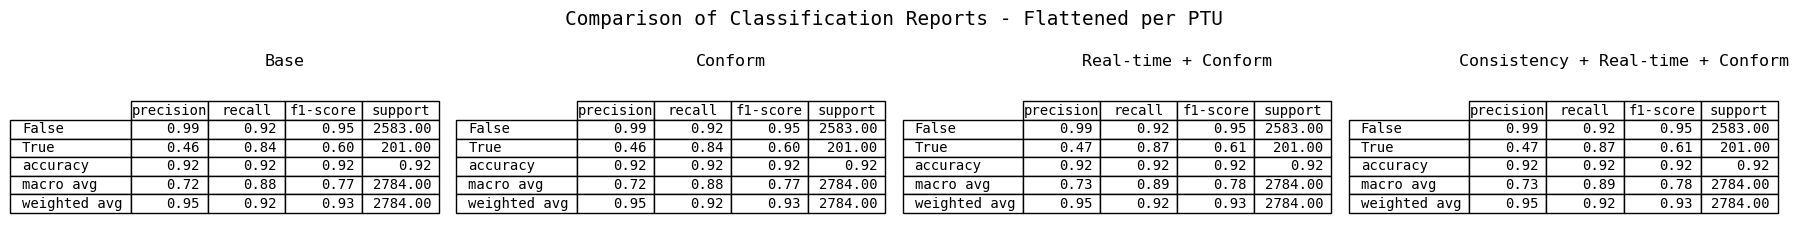

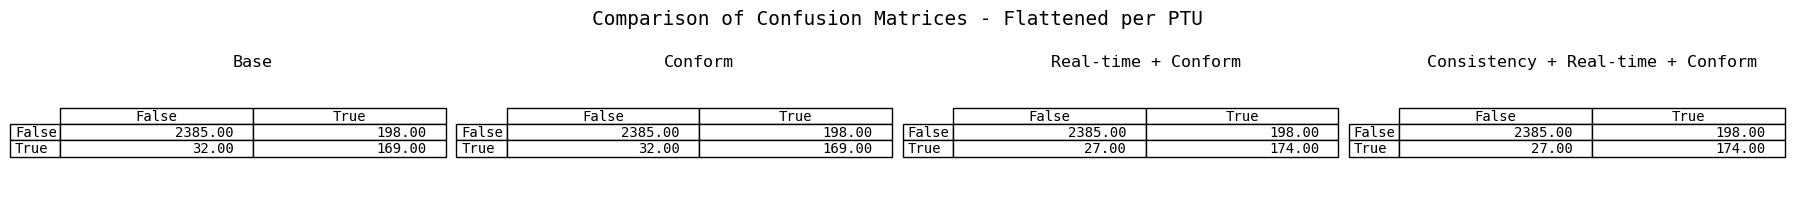

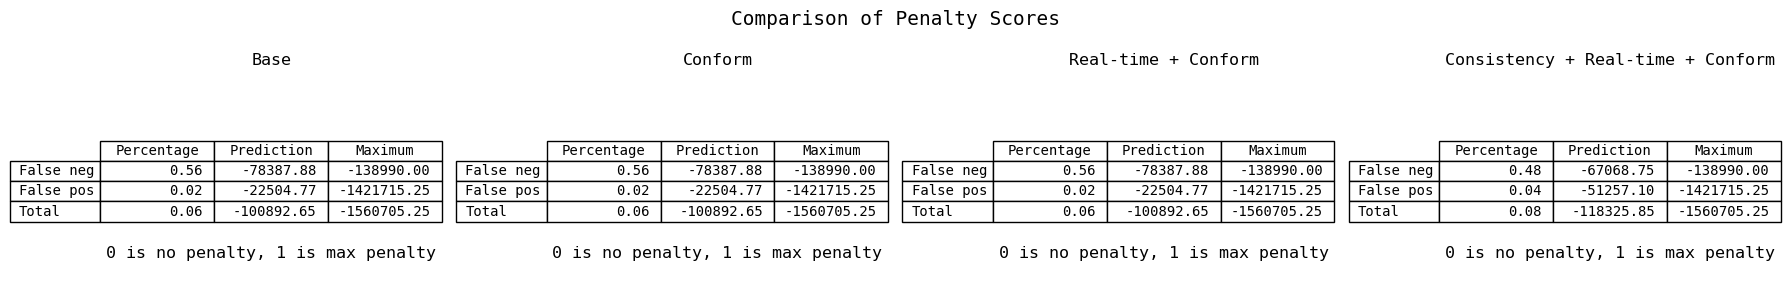

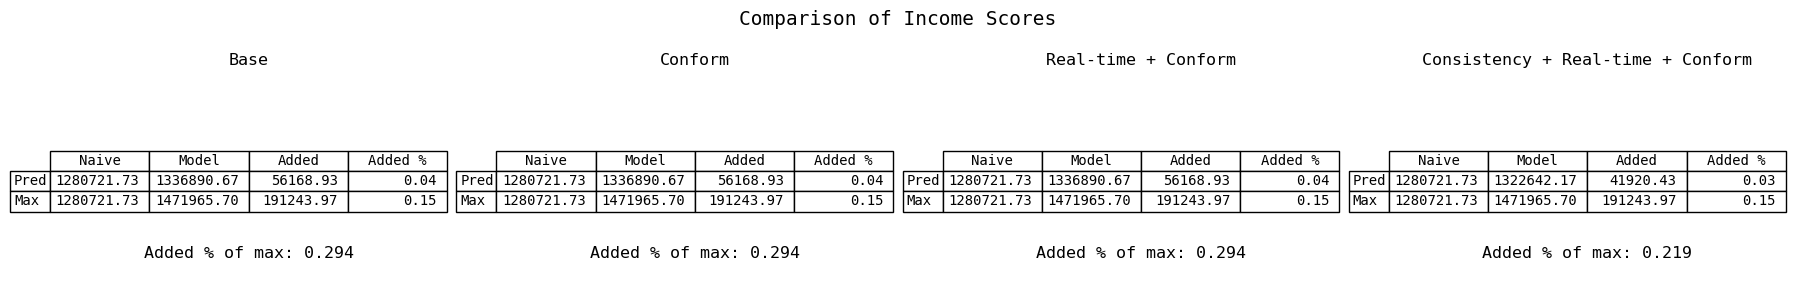

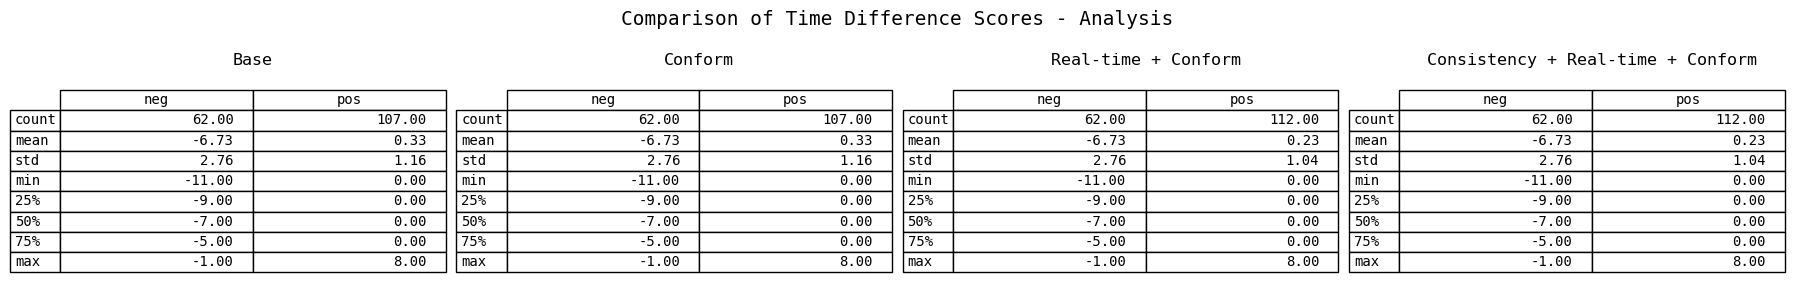

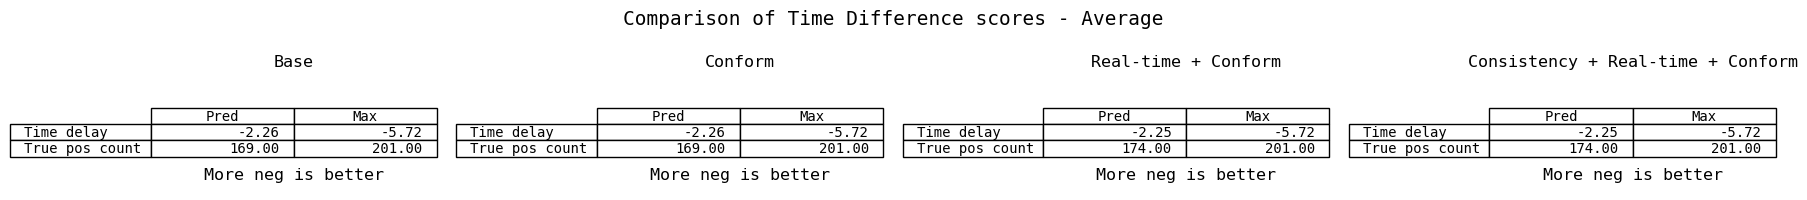

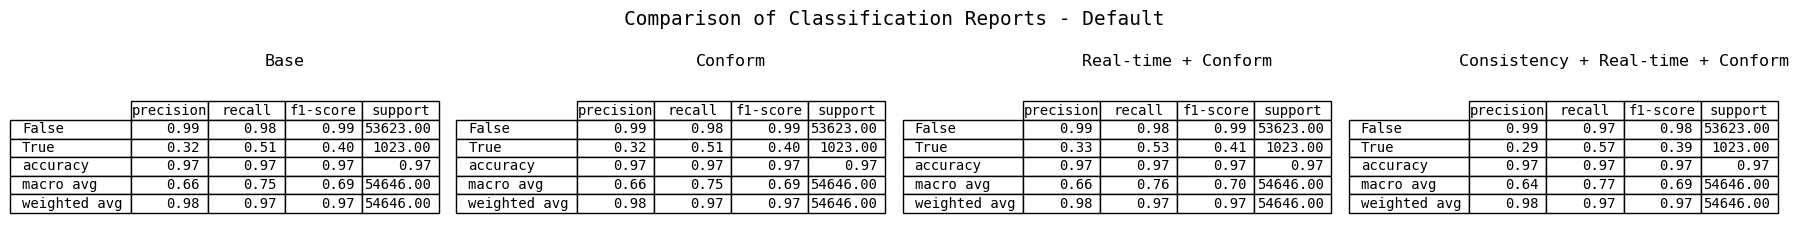

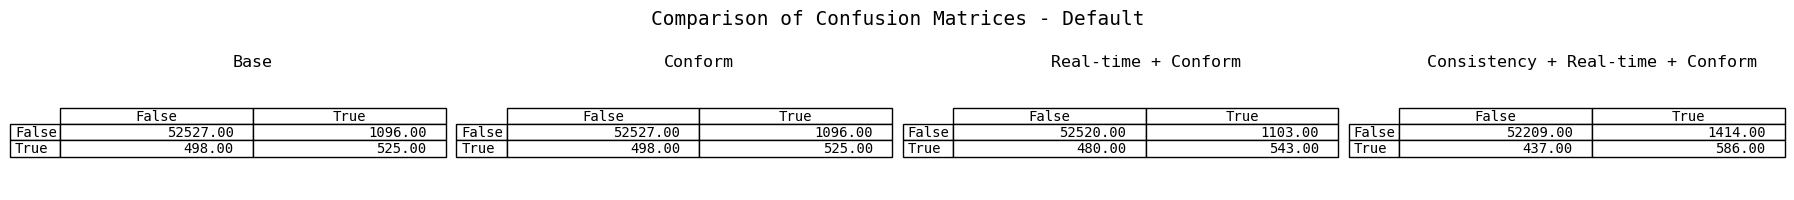

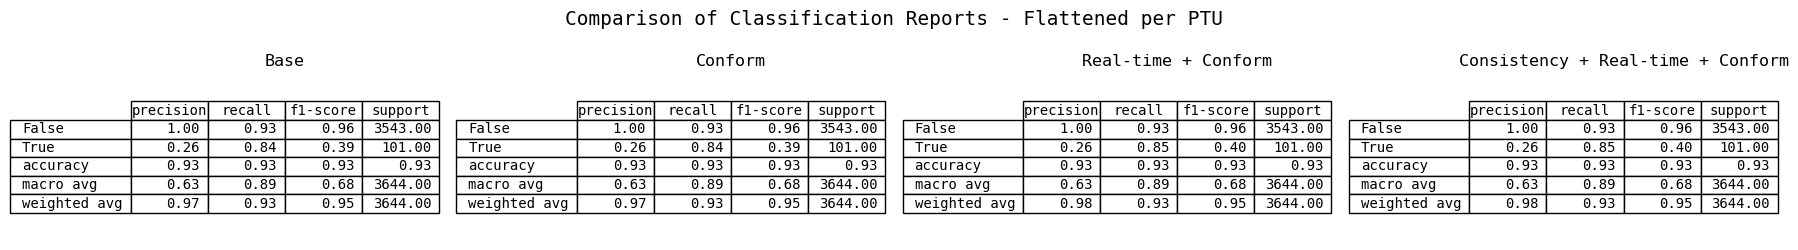

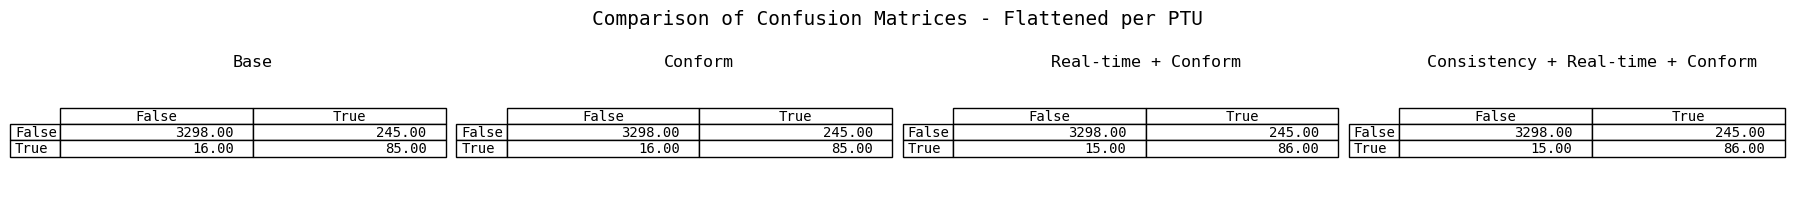

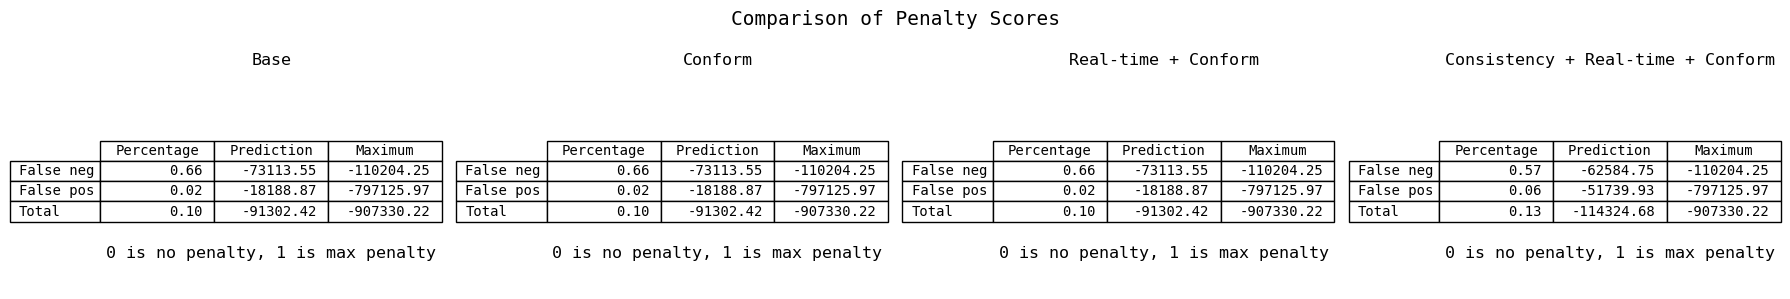

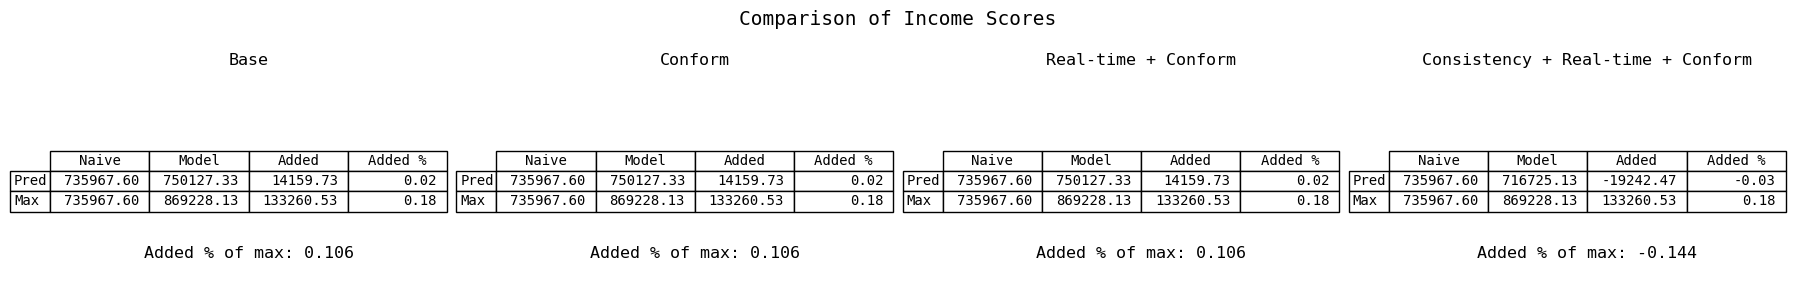

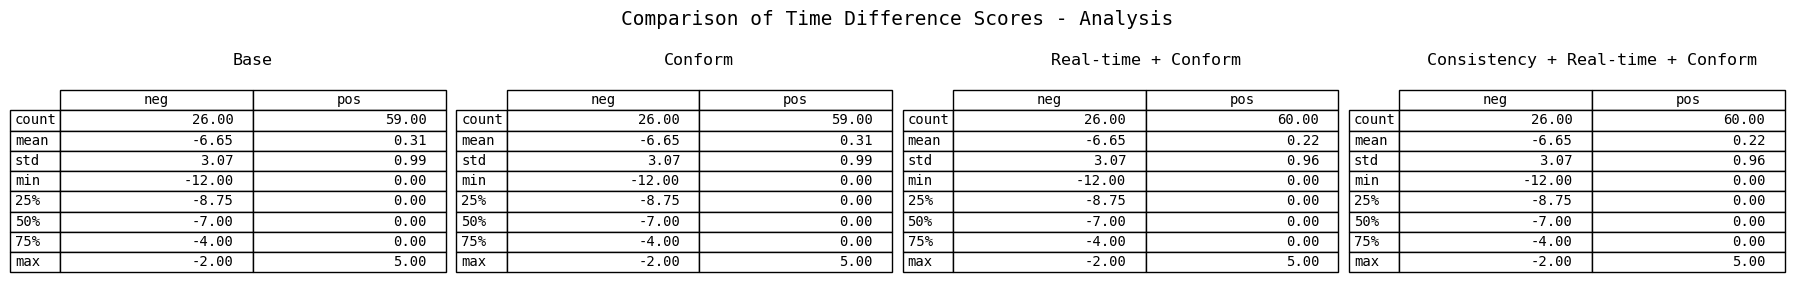

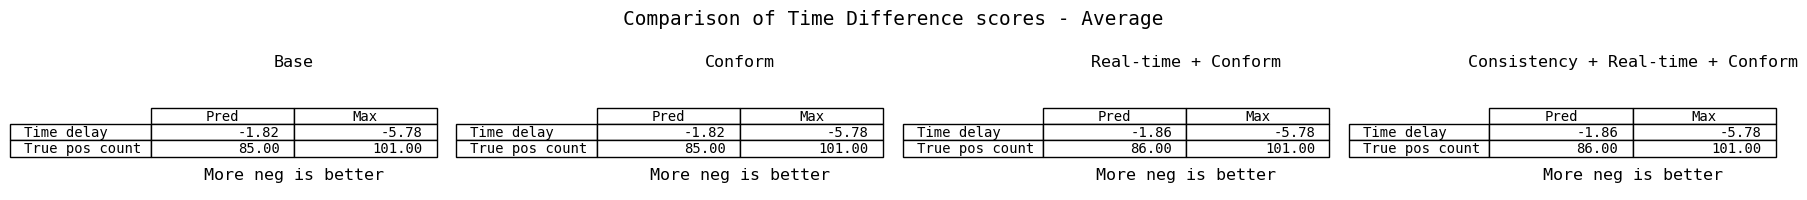

In [3]:
p_tr, _ = test(best2[0], splits["train"][0])
show_metrics_adjusted(splits["train"][3], p_tr, version=version)

p_va, _ = test(best2[0], splits["valid"][0])
show_metrics_adjusted(splits["valid"][3], p_va, version=version)

p_te, _ = test(best2[0], splits["test"][0])
show_metrics_adjusted(splits["test"][3], p_te, version=version)

In [4]:
for split in splits.values():
    print(split[3]["ptu_id"].nunique() / 96)

86.0
29.0
37.958333333333336
115.0
152.95833333333334


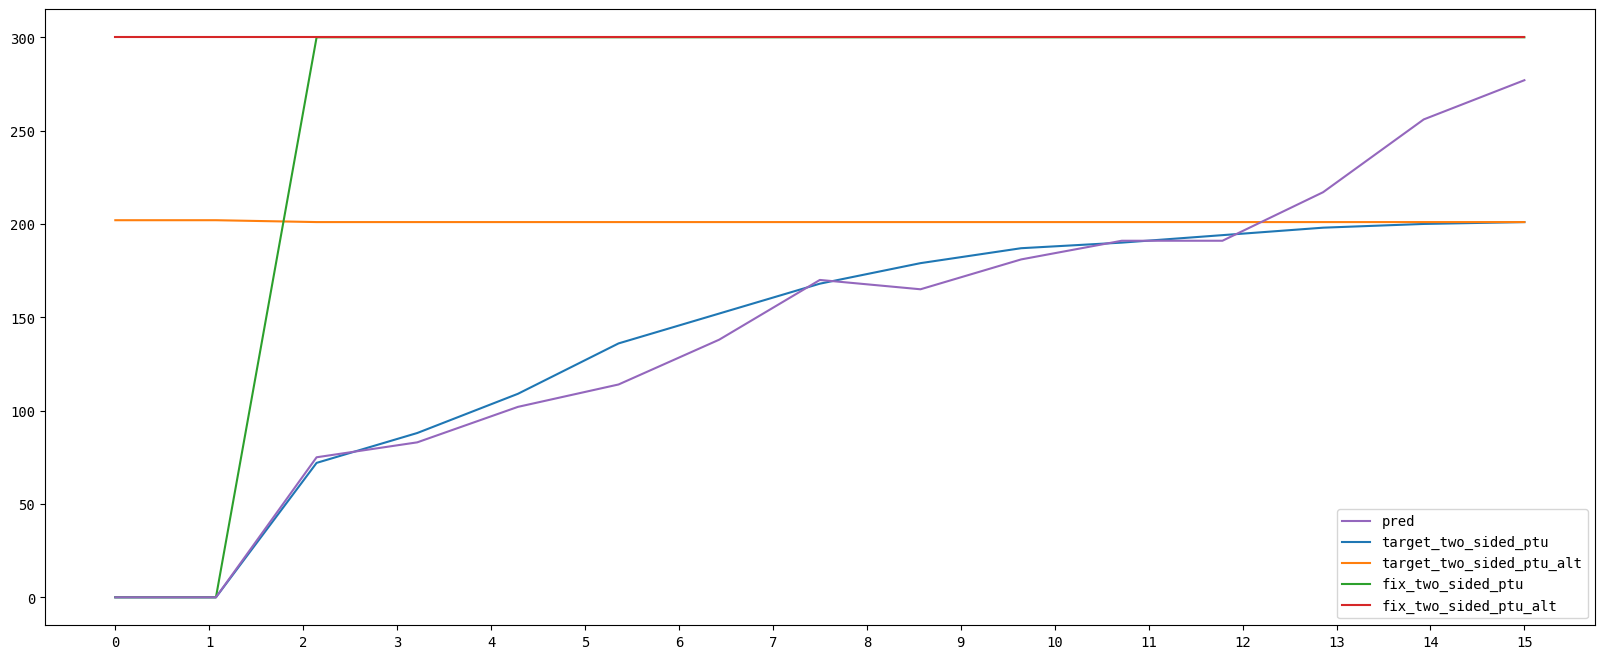

In [5]:
targets = [
    "target_two_sided_ptu",
    "target_two_sided_ptu_alt",
    # "target_two_sided_ptu_realtime",
    "fix_two_sided_ptu",
    "fix_two_sided_ptu_alt",
    # "fix_two_sided_ptu_realtime",
    "pred"
]
agg_dict = {t: "sum" for t in targets}
view = splits[test_set][3]
view["pred"] = p2
items = 15
flat_df = view.groupby("minute_in_ptu").agg(agg_dict)
flat_df.index = np.linspace(0, items, items)

for t in targets:
    plot_against_index(flat_df[t], show=False)
plt.xticks(range(0, items + 1, 1))
show_graph()